In [12]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib
rng = np.random.default_rng(seed=0x1337)

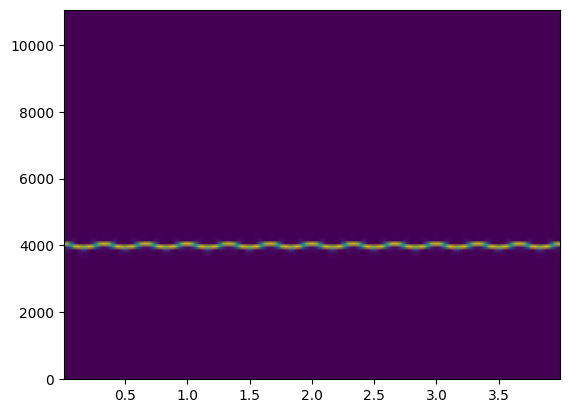

In [267]:
Fs = 22.1e3
Tlen = 4
tt = np.arange(0, Tlen, 1/Fs)

fbeacon = 4e3
fm_f = 3

signal = []
Δf = 50 # ±Hz
mod = np.cos(2*np.pi*fm_f*tt)
fm_integral = np.cumsum(mod * Δf / (fbeacon * Fs))
signal = np.cos(2*np.pi*fbeacon*(tt+fm_integral))
true_sweep_f = fbeacon + mod * Δf

# f0 = fbeacon-200
# f1 = fbeacon+200
# t1 = Tlen
# signal = scipy.signal.chirp(tt, f0, t1, f1)
# true_sweep_f = f0 + (f1-f0) * tt/t1

spf, spt, spSxx = scipy.signal.spectrogram(signal, Fs)
plt.pcolormesh(spt, spf, spSxx, shading='gouraud')

In [268]:
def freqzplot(b, a):
    w, h = scipy.signal.freqz(b, a)
    fig, ax1 = plt.subplots()
    ax1.plot(w, 20*np.log10(abs(h)), 'b')
    ax1.set_xlabel("$\omega$ [rad/sample]")
    ax1.set_ylabel("amplitude [dB]", color='b')

    ax2 = ax1.twinx()
    ax2.plot(w, np.unwrap(np.angle(h)), 'g')
    ax2.set_ylabel('angle [rad]', color='g')
    ax2.grid(True)
    ax2.axis('tight')

    return fig, [ax1, ax2]

In [269]:
class Biquad:
    def __init__(self, b, a):
        # x = input
        # y = output
        # x1 = x1 with z^-1 delay, x2 follows..
        assert len(a) == len(b) and len(a) == 3
        self.a, self.b = a, b

        self.x1 = self.x2 = 0
        self.y1 = self.y2 = 0

        # normalize (1/a[0] term)
        self.b /= a[0]
        self.a[1:] /= a[0]

    def __call__(self, x):
        # uses the obvious difference eq, not one of the rearrangements
        y = (
            self.b[0] * x
            + self.b[1] * self.x1
            + self.b[2] * self.x2
            - self.a[1] * self.y1
            - self.a[2] * self.y2
        )

        self.x2, self.y2 = self.x1, self.y1
        self.x1, self.y1 = x, y

        return y


class PLL:
    """Simple medium-bandwidth PLL with lock detection."""

    def __init__(
        self,
        fcenter,
        Fs,
        loop_gain=0.05,
        loop_filter=None,
        output_filter=None,
        lock_filter=None,
        lock_threshold=0.1,
    ):
        self.fcenter = fcenter
        self.Fs = Fs
        self.t = 0

        self.loop_filter = loop_filter or Biquad(
            *scipy.signal.butter(2, 100, "low", fs=Fs)
        )
        self.output_filter = output_filter or Biquad(
            *scipy.signal.butter(2, 10, "low", fs=Fs)
        )
        self.lock_filter = lock_filter or Biquad(
            *scipy.signal.butter(2, 10, "low", fs=Fs)
        )

        self.lock_threshold = lock_threshold

        self.loop_gain = loop_gain
        self.fm_integral = 0  # integrate control frequency into phase to drive the reference oscillator

        self.ref_signal = 0
        self.ref_signal_delay = 0

    def __call__(self, x):
        phase_detect = x * self.ref_signal * self.loop_gain
        control = self.loop_filter(phase_detect)
        output = self.output_filter(phase_detect)

        self.fm_integral += control / self.Fs
        self.ref_signal = np.cos(2 * np.pi * self.fcenter * (self.t + self.fm_integral))

        # -- lock detection
        # we need d/dt ref_signal shifted by φ=+π/2. just finite diff
        quadrature_ref = (
            (self.ref_signal - self.ref_signal_delay)
            * self.Fs
            / (2 * np.pi * self.fcenter)
        )
        self.ref_signal_delay = self.ref_signal

        pll_lock = self.lock_filter(-quadrature_ref * x)
        locked = pll_lock > 0.1

        # do our own time evolution
        self.t += 1 / self.Fs

        return {'locked': locked, 'lock_detector': pll_lock, 'output': output, 'phase_detect': phase_detect}

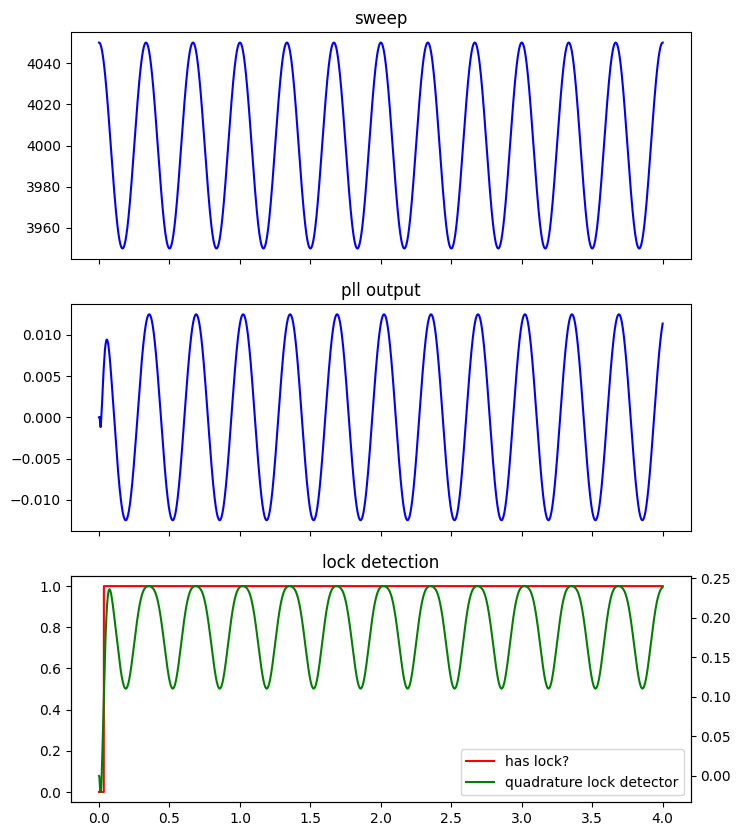

In [290]:
pll = PLL(fbeacon, Fs, loop_gain=0.1)

trace_output = []
trace_lock_detector = []
trace_locked = []
trace_phase_detect = []
for t, sample in zip(tt, signal):
    res = pll(sample/2)
    trace_output.append(res['output'])
    trace_lock_detector.append(res['lock_detector'])
    trace_locked.append(res['locked'])
    trace_phase_detect.append(res['phase_detect'])

# -- viz pll
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
ax1.plot(tt, true_sweep_f, label='sweep frequency', c='b')
ax1.set_title('sweep')

ax2.plot(tt, trace_output, label='PLL output', c='b')
ax2.set_title('pll output')

ax3.set_title('lock detection')
lns1 = ax3.plot(tt, trace_locked, label='has lock?', c='r')
ax4 = ax3.twinx()
lns2 = ax4.plot(tt, trace_lock_detector, label='quadrature lock detector', c='g')
lns = lns1 + lns2
ax4.legend(lns, [l.get_label() for l in lns])

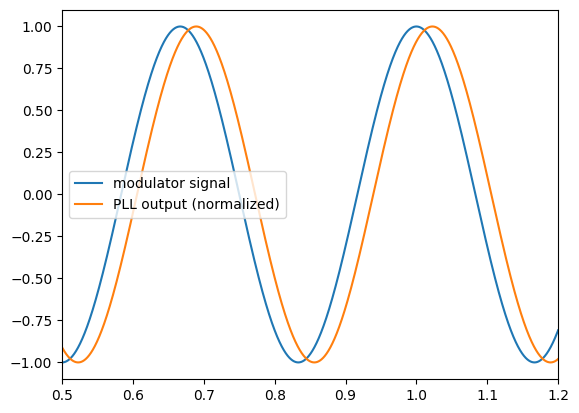

In [329]:
plt.plot(tt, mod/np.abs(np.max(mod)), label='modulator signal')
plt.plot(tt, trace_output/np.abs(np.max(trace_output)), label='PLL output (normalized)')
plt.xlim(0.5, 1.2)
plt.legend()

(<Figure size 640x480 with 2 Axes>,
 [<Axes: xlabel='$\\omega$ [rad/sample]', ylabel='amplitude [dB]'>,
  <Axes: ylabel='angle [rad]'>])

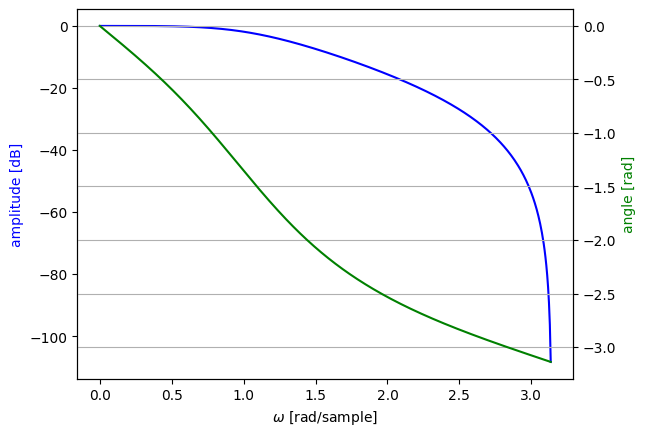

In [172]:
b, a = scipy.signal.butter(2, fbeacon, 'low', fs=Fs)
freqzplot(b, a)

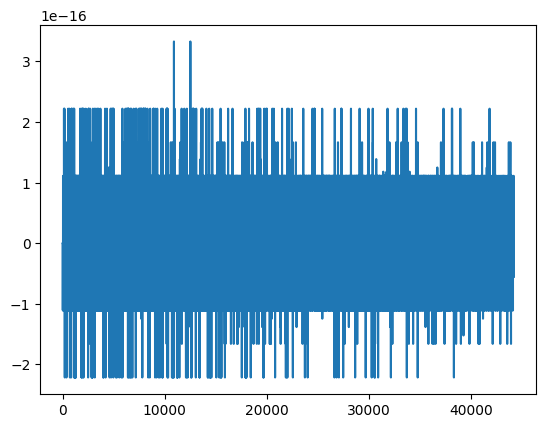

In [126]:
filt = Biquad(b, a)
plt.plot(np.array([filt(sample) for sample in signal]) - scipy.signal.lfilter(b, a, signal))